# Homework 2: Topic Modeling

## Pre-Question Data Preprocessing

### Load Files

In [1]:
#import files
import os
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', 199)  
import string

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles  
all_files = getListOfFiles('./bbc')
docs=list()

for f in all_files[1:]:
    with open(f,'r',encoding = 'unicode_escape') as txt:
        docs.append(txt.read())

### Data Cleaning and Tabulation

In [2]:
#create a dataframe
docs = pd.DataFrame({'content': docs,"document":all_files[1:]})

#record document topics
docs['original folder'] = docs['document'].str[6:-8]

Before we create the document-term matrix, we need to preprocess our data:
1. **Remove puncuation**: We want to avoid the situation where "maybe" and "maybe?" are considered as different words due to puncuation.
2. **Remove stop words**: Stop words are very likely to appear as top words in each topic, but they don't give us information about what the topic is about. This process will be performed in the CountVectorizer below.
3. **Lemmatization**: Removing inflectional endings and returning the base or dictionary form of a word (i.e. car, cars, car's, cars' $\Rightarrow$ car) allow having more words related to the topic so he can have a better understanding of it. 

In [3]:
import spacy

#remove punctuations and perform tokenization
doc_words = docs['content'].str.replace(r'([^\w\s]+)|(\n)+', ' ').str.split()

#lemmatization
def lemmatization(texts):
    texts_out = []
    for t in texts:
        doc = nlp(" ".join(t)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc]))
    return texts_out

nlp = spacy.load('en')
docs['lemmatized'] = lemmatization(doc_words)

### Create Document Term Matrix

When creating the document matrix:

1. I set **max_df = 0.95**, meaning that I only keep words that show up in at most 95% percent of documents because words that show up in all documents are probably not helpful for identifying topics.
2. I set **min_df = 2**, meaning that I only keep words that show up in at least 2 documents. I want to have the words that can identify common topics among different documents and ignore those too unique words.
3. I removed stop words, which are not significant and occur frequently.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df = 0.95, min_df=2,stop_words='english')

In [5]:
doc_word_matrix = cv.fit_transform(docs['lemmatized'])

### LDA

Even though we have 5 topics in the documents, there are lots of subtopics, so I set the number of topics k = 10. Further exploration on the numbers of topics will be discussed in Question 3. To ensure the result can be reproduced, I set the random state to be 4559. Discussion on random initialization will also be presented in Question 5.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, random_state=4559)

Based on the setting, I created two matrixs:

In [8]:
topic_word_matrix10 = lda.fit(doc_word_matrix) 
doc_topic_matrix10 = lda.fit_transform(doc_word_matrix)

## Question 1: Understand Topics

The conventional method that we use to identify a topic is by looking at its top words. However, the number of top words often time has great influence on our interpretation and confidence in the topic.

In [12]:
#import packages: math, matplotlib, seaborn
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
def top_words_for_topic(n, topic_word_matrix,cv,table = True, graph=True):
    topics = list(range(1,len(topic_word_matrix.components_)+1))
    words = []
    if graph:
        f, axes = plt.subplots(5, 2, figsize=(20, 30), sharex=True)
    for i,topic in enumerate(topic_word_matrix.components_):
        prob = topic/sum(topic)
        top_words = [cv.get_feature_names()[i] for i in reversed(prob.argsort()[-n:])]
        words.append(top_words)
        top_probs = [prob[i] for i in reversed(prob.argsort()[-n:])]
        if graph:
            if i % 2 == 0:
                sns.barplot(top_probs, top_words,ax=axes[math.floor(i/2), 0])  
                axes[math.floor(i/2), 0].set_title(f"Topic {i+1}")
            else:
                sns.barplot(top_probs, top_words,ax=axes[math.floor(i/2), 1])
                axes[math.floor(i/2), 1].set_title(f"Topic {i+1}")
    if table:       
        return pd.DataFrame({"topic":topics, "top words": words})

For example, when we look at the top 5 words in each topic, we are likely to recognize that each topic is about:

In [14]:
#top 5 words
t5 = top_words_for_topic(5,topic_word_matrix10,cv,True,False)
t5['possible theme'] = ['report','game','politics','game','oil business','sports','business','law','film','digital entertainment']
t5

,topic,top words,possible theme
0,1,"[say, year, people, new, report]",report
1,2,"[say, use, game, people, user]",game
2,3,"[say, mr, labour, party, election]",politics
3,4,"[say, year, win, world, set]",game
4,5,"[say, company, yukos, oil, mr]",oil business
5,6,"[say, game, england, play, player]",sports
6,7,"[say, year, market, company, firm]",business
7,8,"[say, mr, law, court, police]",law
8,9,"[film, good, year, award, star]",film
9,10,"[tv, mobile, say, music, digital]",digital entertainment


However, even though when we look at one more word in each topic, we cannot be confident in the statement above. For example, because the word "technology" appears in topic 10, we may consider refine the theme of the topic from "digital entertainment" to "digital technology." Similarly, for topic 1, because of the word "government," we may reconsider this topic as "government-related report."

In [67]:
#top 6 words
t6 = top_words_for_topic(6,topic_word_matrix10,cv,True,False)
t6['possible theme (5)'] = ['report','game','politics','game','oil business',
                                             'sports','business','law','film',
                                             'digital entertainment']
t6['possible theme (6)'] = ['government', 'mobile game', 'politics',
                                             'game','oil','sports','business','law','film',
                                             'technology']
t6

,topic,top words,possible theme (5),possible theme (6)
0,1,"[say, year, people, new, report, government]",report,government
1,2,"[say, use, game, people, user, phone]",game,mobile game
2,3,"[say, mr, labour, party, election, blair]",politics,politics
3,4,"[say, year, win, world, set, final]",game,game
4,5,"[say, company, yukos, oil, mr, plan]",oil business,oil
5,6,"[say, game, england, play, player, win]",sports,sports
6,7,"[say, year, market, company, firm, price]",business,business
7,8,"[say, mr, law, court, police, government]",law,law
8,9,"[film, good, year, award, star, win]",film,film
9,10,"[tv, mobile, say, music, digital, technology]",digital entertainment,technology


And when we look at the top 10 words in each topic, the topics seems to change again. For example, topic 2 now seems to be about technology rather than mobile games, and topic 10 looks more related to online streaming service.

In [16]:
#top 10 words
top_words_for_topic(10,topic_word_matrix10,cv,True,False)

,topic,top words
0,1,"[say, year, people, new, report, government, work, uk, rate, make]"
1,2,"[say, use, game, people, user, phone, computer, make, software, net]"
2,3,"[say, mr, labour, party, election, blair, people, government, minister, brown]"
3,4,"[say, year, win, world, set, final, make, open, time, play]"
4,5,"[say, company, yukos, oil, mr, plan, russian, firm, court, group]"
5,6,"[say, game, england, play, player, win, club, time, team, make]"
6,7,"[say, year, market, company, firm, price, growth, share, rise, bank]"
7,8,"[say, mr, law, court, police, government, eu, case, right, tell]"
8,9,"[film, good, year, award, star, win, say, music, include, new]"
9,10,"[tv, mobile, say, music, digital, technology, service, people, video, dvd]"


So the important problem with having to pick a number of words to look at in each topic is that different numbers tell different stories. If we just arbitrarily pick the number without considering the probability distribution of the words, the topic we extract from the words we believe is important can be very misleading. For example, from the barplot below, we can see that word 5 and word 6 and even several words after in each topic have approximately the same probability. Therefore, rather than looking at the top 5 words, we may want to look at several more.

Another potential issue is that we simply take the threshold of number of words and apply it to all topics while different topics have different word distributions. Probably it is more accurate to look at top 10 words for topic 3 because there is a sharp decrease in probability after that while to look at top 20 words for topic 1 because the distribution more even.

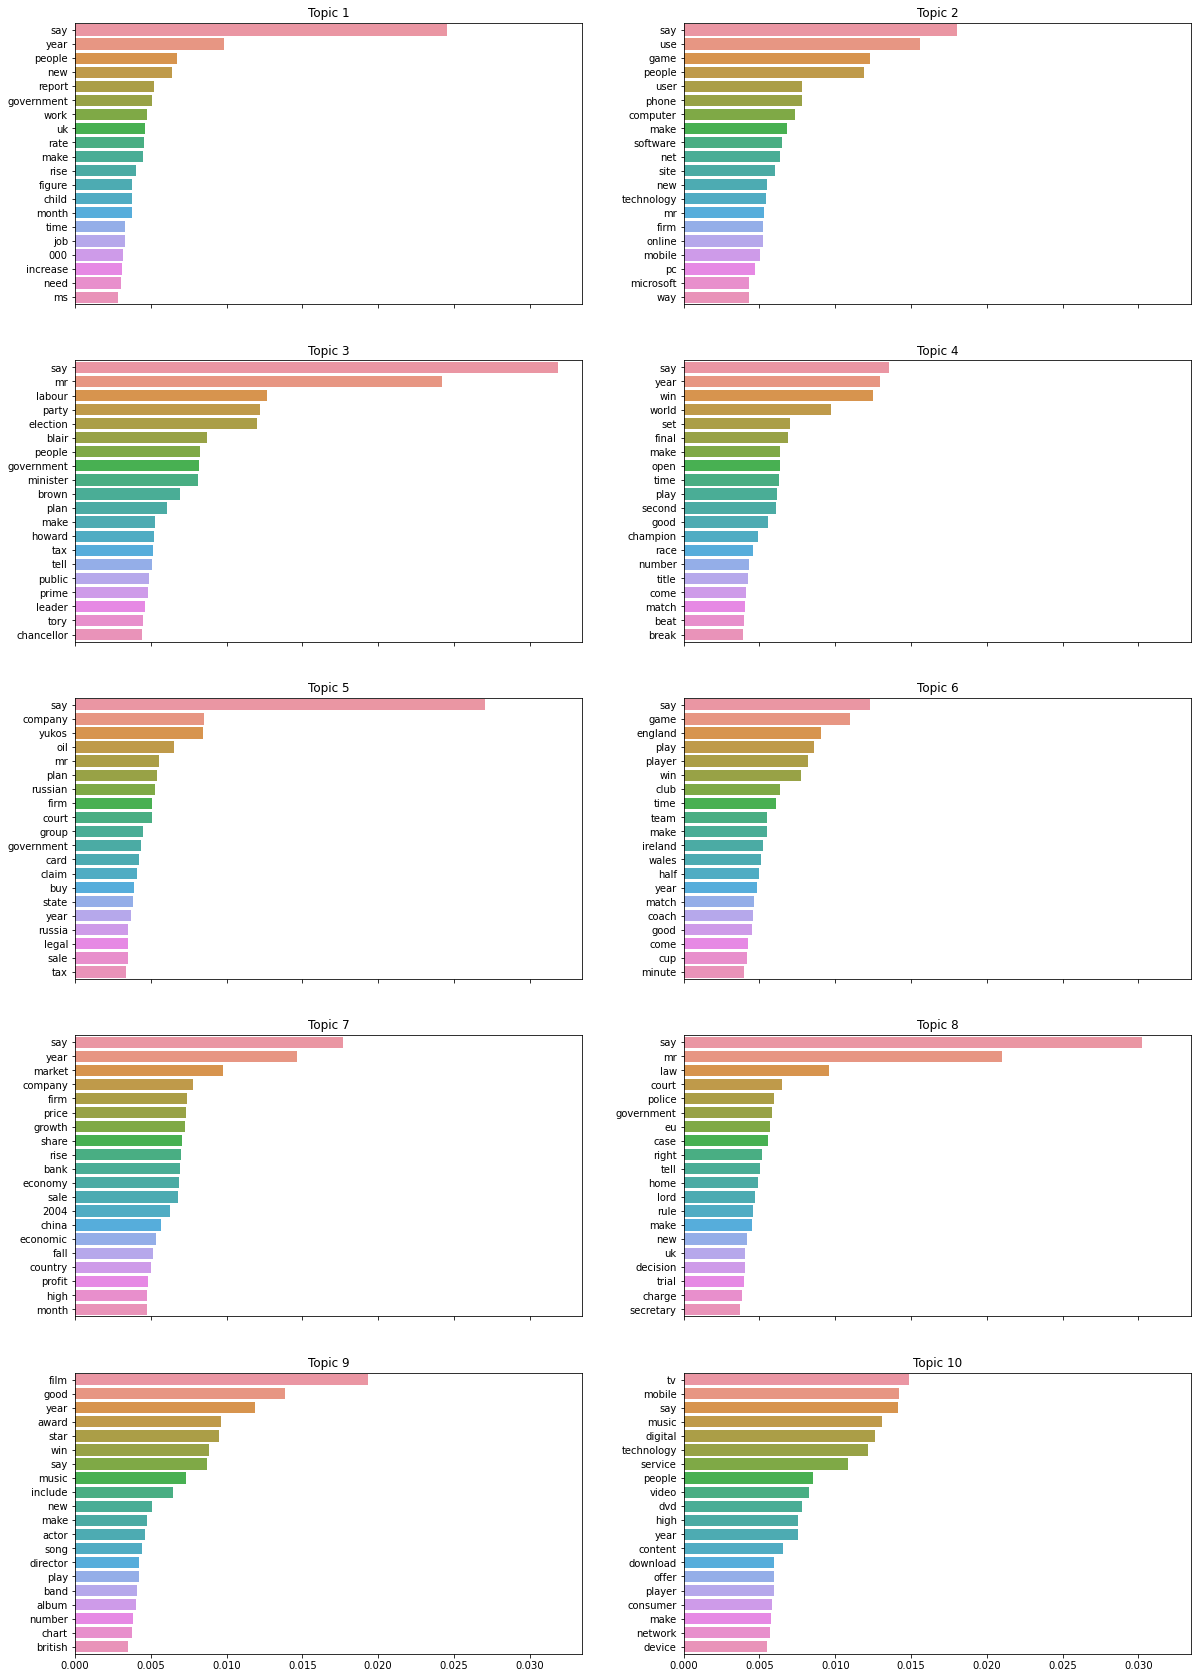

In [17]:
top_words_for_topic(20,topic_word_matrix10,cv,False,True)

# Question 2: Examine the Document Topic Probabilities

### Number of Documents in Each Topic

To examine how many documents are about each topic, let's consider the topic of a document to be the topic of highest probability:

In [18]:
docs['topic'] = doc_topic_matrix10.argmax(axis=1) + 1

Now look at the number of documents in each topic:

In [19]:
docs['topic'].value_counts().sort_index()

1     179
2     262
3     261
4     176
5      94
6     338
7     330
8     166
9     333
10     86
Name: topic, dtype: int64

Text(0.5, 1.0, 'Distribution of Documents Over Topics')

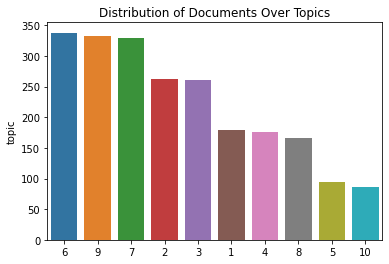

In [23]:
#Distribution of Documents Over Topics
sns.barplot(x=docs['topic'].value_counts().index, y=docs['topic'].value_counts(),
            order=docs['topic'].value_counts().index)
plt.title("Distribution of Documents Over Topics")

We can see that documents are more centered at topic 6(sports), 7(business), and 9(film). One reason can be that these topics are more prevalent among the documents. According to the folder categories, we have more documents in sports and business.

In [24]:
docs['original folder'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: original folder, dtype: int64

Now let's see the document distribution within each topic. From the table below, we can observe that topic 6,7,and 9 are centered on 1 specific category.

In [25]:
docs.groupby(['topic'])['original folder'].value_counts()

topic  original folder
1      business            71
       politics            59
       tech                35
       entertainment       14
2      tech               255
       business             4
       politics             2
       entertainment        1
3      politics           247
       business            10
       entertainment        2
       sport                2
4      sport              158
       entertainment       13
       tech                 4
       politics             1
5      business            61
       entertainment       11
       politics            11
       sport                6
       tech                 5
6      sport              335
       tech                 2
       politics             1
7      business           319
       tech                 5
       entertainment        4
       politics             2
8      politics            92
       business            43
       tech                14
       entertainment       13
       sport     

We can also see that topics with fewer number of documents, such as topic 1 and 8, have a more even distribution of documents. These topics may capture the commonalities in documents from different folders. Are these phenomenons reflected on the top documents in each topic?

### Top Documents in Each Topic

In [26]:
docs['max topic probabilities'] = doc_topic_matrix10.max(axis=1)

In [27]:
#find top documents in each topic
gp20 = docs.groupby(['topic'])['max topic probabilities'].nlargest(20)
gp20=gp20.replace(to_replace = gp20.values, 
           value = (docs.loc[gp20.index.get_level_values(1),'original folder'] + " " + 
                    gp20.values.astype('str') ).values)
gp20[(gp20.index.get_level_values(0)==1)|(gp20.index.get_level_values(0)==8)]

topic      
1      2022             tech 0.9968633595766595
       2179             tech 0.9968633595766595
       2221             tech 0.9953595903648865
       588          business 0.9947356501994005
       644          business 0.9930759509466004
       1516         politics 0.9402450740733103
       1657         politics 0.9259247708237586
       1498         politics 0.9131727004873222
       1791         politics 0.9130905915365097
       1761         politics 0.8976025796912025
       1861             tech 0.8820769782768075
       417          business 0.8634806172500454
       1422          politics 0.841655275911505
       1446         politics 0.8326128553777089
       1760         politics 0.7978315269989821
       1544         politics 0.7976617077553526
       260     entertainment 0.7971740553247364
       441          business 0.7921457281210003
       808          business 0.7881973936790796
       679          business 0.7826919840420274
8      1710         politics

The result is yes. Looking at the top 20 documents in each topic (above), we can discover that topic 1 and topic 8 have documents from different folders while other topics have documents that are consistently from one topic. (For the space reason, only topic 1 and 8 are printed.) Especially, topic 1 have top documents from four different folders. 

### Documents that Assign Substantial Weight to More Than One Topic

One good way to measure whether a document spreads weight over multiple topics is **Entropy**. Looking at the histogram and entropy below, we can see that about a quarter of documents have entrophy larger than 1, which in this case is considered as high entrophy based on the observation in the actual doc-topic probability distributions.

Text(0.5, 0.98, 'Entropy of Document-Topic Distributions of Documents')

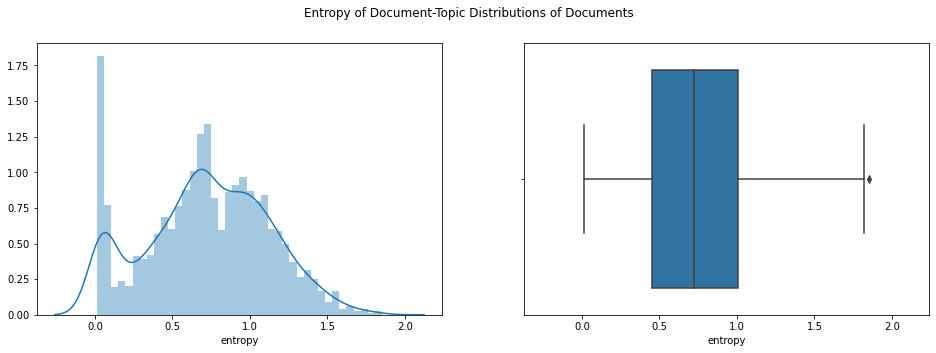

In [30]:
#Calculate Entropy
from scipy.stats import entropy 
import scipy.stats 

docs['entropy'] = entropy(doc_topic_matrix10, axis=1)

f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
sns.distplot(docs['entropy'],bins=40, ax=axes[0])
sns.boxplot(docs['entropy'], ax=axes[1])
f.suptitle('Entropy of Document-Topic Distributions of Documents')

Comparing the median entropy among different folders, documents from technology and entertainment folder tend to  have higher entropy value.

In [74]:
#Calculate Entropy for Each Folder
#f, axes = plt.subplots(5, 2, figsize=(16, 20), sharex=True)
#for i,folder in enumerate(docs['original folder'].unique()):
 #       sns.distplot(docs.loc[docs['original folder']==folder, 'entropy'],bins=40, ax=axes[i, 0])
 #       sns.boxplot(docs.loc[docs['original folder']==folder, 'entropy'], ax=axes[i, 1])
 #       axes[i,0].set_title(f"{folder}")
  #      axes[i,1].set_title(f"{folder}")
docs['entropy'].groupby(docs['original folder']).median().sort_values(ascending=False)

original folder
tech             0.833017
entertainment    0.820671
business         0.791817
politics         0.696227
sport            0.565583
Name: entropy, dtype: float64

The high entrophy of documents from technology and entertainment is also shown by the fact that these two folders have the highest proportion of documents with entrophy greater than 1. It means that technology and entertainment have lots of subtopics that we can identify and explore with details.

In [33]:
docs.loc[docs['entropy']>=1,'original folder'].value_counts()/docs['original folder'].value_counts()

business         0.286275
entertainment    0.357513
politics         0.242206
sport            0.113503
tech             0.324190
Name: original folder, dtype: float64

Overall, the higher entrophy of a document means that the document spreads weights more evenly over multiple topics. In the current model, we performed hard assignment and consider the topic of a document to be the topic of highest probability, but the assignment doesn't necessarily grasp the whole picture of the document.

# Question 3:  Choice on Number of Topics k

When we categorize documents into different topics, we are exploring the structure of the documents available. With different number of topics, the data structure will also be different. In the question, let's explore 3 different numbers of topics -- 2,11,and 20 -- and see how the data structure changes compared to the original model with 10 topics by looking at the similarity of top words in pairwise topics. 

In [34]:
#Build models with k=2,11,20
lda2 = LatentDirichletAllocation(n_components=2, random_state=4559)
topic_word_matrix2 = lda2.fit(doc_word_matrix) 

lda11 = LatentDirichletAllocation(n_components=11, random_state=4559)
topic_word_matrix11 = lda11.fit(doc_word_matrix) 

lda20 = LatentDirichletAllocation(n_components=20, random_state=4559)
topic_word_matrix20 = lda20.fit(doc_word_matrix) 

In [37]:
import numpy as np
def count_of_similar_top_words(matrix1, matrix2,k,cv1,cv2):
    pairwise_matrix = np.zeros((len(matrix1.components_),len(matrix2.components_)))
    top_1 = top_words_for_topic(k,matrix1,cv1,True,False)
    top_2 = top_words_for_topic(k,matrix2,cv2,True,False)
    
    for i,t1 in enumerate(top_1['top words']):
        for j, t2 in enumerate(top_2['top words']):
            pairwise_matrix[i][j]= len(set(t1).intersection(set(t2)))
            
    return pd.DataFrame(pairwise_matrix,index=range(1,len(matrix1.components_)+1),columns =range(1,len(matrix2.components_)+1))

## K=2 VS K=10

Based on the count of similar top words, in the model with only 10 topics, each of the topics share relatively many words with one of the topics in the 2-topic model. It can be said that the 10 topics are roughly "divided" into 2 general topics.

In [38]:
count_of_similar_top_words(topic_word_matrix2,topic_word_matrix10,20,cv,cv)

,1,2,3,4,5,6,7,8,9,10
1,8.0,6.0,12.0,3.0,7.0,3.0,7.0,7.0,4.0,4.0
2,6.0,8.0,3.0,9.0,2.0,10.0,2.0,3.0,9.0,8.0


However, looking at the top 20 words of the 2-topic model, we can't really give a label to each topic because they include so many different topics. Therefore, the 2-topic model is much harder to interpret than the 10-topic model.

In [39]:
top_words_for_topic(20,topic_word_matrix2,cv,True,False)

,topic,top words
0,1,"[say, mr, year, government, new, make, people, labour, company, party, election, plan, tell, minister, uk, country, firm, rise, market, blair]"
1,2,"[say, year, game, win, make, good, use, people, play, time, new, music, player, world, film, like, come, just, mobile, technology]"


## K=11 VS K=10

Comparing the 11-topic model with the 10-topic model, we can see that topic 1 to 10 in both models share many top words along the diagonal of the table, meaning these topics are well preserved, while topic 11 shares relatively few words with the original 10 topics.

In [40]:
count_of_similar_top_words(topic_word_matrix10,topic_word_matrix11,20,cv,cv)

,1,2,3,4,5,6,7,8,9,10,11
1,19.0,4.0,4.0,4.0,2.0,4.0,3.0,5.0,4.0,5.0,5.0
2,4.0,18.0,4.0,2.0,3.0,3.0,2.0,4.0,3.0,6.0,3.0
3,4.0,4.0,20.0,2.0,5.0,2.0,1.0,6.0,2.0,3.0,2.0
4,4.0,2.0,2.0,19.0,1.0,9.0,2.0,2.0,6.0,3.0,5.0
5,3.0,3.0,5.0,2.0,18.0,2.0,5.0,4.0,2.0,2.0,2.0
6,4.0,3.0,2.0,9.0,1.0,19.0,2.0,2.0,6.0,4.0,5.0
7,5.0,2.0,1.0,2.0,3.0,2.0,19.0,1.0,2.0,3.0,2.0
8,5.0,4.0,5.0,2.0,5.0,2.0,1.0,19.0,3.0,3.0,4.0
9,4.0,3.0,2.0,6.0,1.0,6.0,2.0,3.0,14.0,5.0,11.0
10,5.0,5.0,3.0,3.0,1.0,4.0,3.0,2.0,4.0,19.0,4.0


Also, topic 9 in the 10-topic model seems to be decomposed into topic 9 and 11 in the 11-topic model according to corresponding counts. We can also tell this from the top word table below: top words of the old topic 9 related film and music are divided into new topic 9 and 11 by these two categories.

In [41]:
top_words_for_topic(20,topic_word_matrix10,cv,True,False)

,topic,top words
0,1,"[say, year, people, new, report, government, work, uk, rate, make, rise, figure, child, month, time, job, 000, increase, need, ms]"
1,2,"[say, use, game, people, user, phone, computer, make, software, net, site, new, technology, mr, firm, online, mobile, pc, microsoft, way]"
2,3,"[say, mr, labour, party, election, blair, people, government, minister, brown, plan, make, howard, tax, tell, public, prime, leader, tory, chancellor]"
3,4,"[say, year, win, world, set, final, make, open, time, play, second, good, champion, race, number, title, come, match, beat, break]"
4,5,"[say, company, yukos, oil, mr, plan, russian, firm, court, group, government, card, claim, buy, state, year, russia, legal, sale, tax]"
5,6,"[say, game, england, play, player, win, club, time, team, make, ireland, wales, half, year, match, coach, good, come, cup, minute]"
6,7,"[say, year, market, company, firm, price, growth, share, rise, bank, economy, sale, 2004, china, economic, fall, country, profit, high, month]"
7,8,"[say, mr, law, court, police, government, eu, case, right, tell, home, lord, rule, make, new, uk, decision, trial, charge, secretary]"
8,9,"[film, good, year, award, star, win, say, music, include, new, make, actor, song, director, play, band, album, number, chart, british]"
9,10,"[tv, mobile, say, music, digital, technology, service, people, video, dvd, high, year, content, download, offer, player, consumer, make, network, device]"


In [42]:
top_words_for_topic(20,topic_word_matrix11,cv,True,False)

,topic,top words
0,1,"[say, year, people, new, government, rate, report, work, rise, uk, month, make, figure, child, increase, time, 000, job, high, need]"
1,2,"[say, use, game, people, phone, user, computer, software, make, net, site, mobile, online, firm, new, mr, technology, pc, mail, internet]"
2,3,"[say, mr, labour, party, election, blair, minister, people, government, brown, plan, howard, make, tax, tell, prime, public, leader, chancellor, tory]"
3,4,"[say, win, year, world, set, final, open, make, play, time, second, good, champion, race, beat, title, come, match, break, olympic]"
4,5,"[say, yukos, company, mr, oil, plan, russian, court, card, firm, claim, government, group, russia, legal, buy, state, case, auction, tax]"
5,6,"[say, game, england, play, player, win, club, time, team, ireland, make, half, year, match, good, coach, come, rugby, minute, cup]"
6,7,"[say, year, market, company, firm, share, growth, price, sale, 2004, rise, bank, economy, china, country, economic, profit, fall, analyst, high]"
7,8,"[say, mr, law, court, government, police, eu, case, tell, right, home, rule, new, lord, make, trial, uk, secretary, charge, minister]"
8,9,"[film, good, year, award, star, win, say, include, actor, director, new, make, play, prize, actress, role, oscar, movie, tv, british]"
9,10,"[say, tv, technology, mobile, digital, music, service, people, video, dvd, high, year, content, consumer, network, download, player, make, device, new]"


Based on this example, we can tell that when we have 10 topics but we choose k=11, the documents will spread out to occupy 11 topics and have a different configuration. In this case, the original topic 9 becomes new topic 9 and 11 while other topics remain unchanged. However, other documents, due to their nature, may have completely different topics with different models.

## K=20 VS K=10

When we double the number of the topics, it hardly works as we ideally think that each of the original 10 topics is decomposed into 2 subtopics. In this case, we can see from the table below that topic 1-9 in both models share pretty much the same words, especially with original and new topic 3 sharing 19 out of 20 words. 

However, several of 20 topics share few words with the original 10 topics, such as the new topic 15 and 16, indicating signs of decomposition and capture of new information.

In [43]:
count_of_similar_top_words(topic_word_matrix10,topic_word_matrix20,20,cv,cv)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,9.0,5.0,4.0,5.0,2.0,3.0,2.0,4.0,4.0,3.0,3.0,12.0,2.0,3.0,5.0,1.0,3.0,5.0,5.0,8.0
2,6.0,14.0,4.0,3.0,3.0,3.0,2.0,4.0,3.0,9.0,2.0,4.0,7.0,2.0,3.0,5.0,7.0,8.0,4.0,1.0
3,6.0,3.0,19.0,2.0,5.0,2.0,1.0,8.0,2.0,2.0,2.0,5.0,2.0,1.0,2.0,2.0,3.0,3.0,5.0,1.0
4,3.0,3.0,2.0,10.0,1.0,7.0,3.0,2.0,7.0,1.0,6.0,3.0,2.0,15.0,3.0,1.0,2.0,3.0,3.0,2.0
5,4.0,1.0,5.0,2.0,15.0,1.0,4.0,5.0,2.0,2.0,2.0,6.0,2.0,2.0,2.0,4.0,3.0,2.0,3.0,3.0
6,3.0,4.0,2.0,7.0,1.0,17.0,2.0,2.0,6.0,1.0,5.0,3.0,2.0,7.0,3.0,2.0,4.0,3.0,3.0,2.0
7,2.0,1.0,1.0,2.0,3.0,1.0,14.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,3.0,4.0,2.0,2.0,12.0
8,7.0,2.0,5.0,3.0,4.0,2.0,1.0,15.0,3.0,2.0,2.0,5.0,2.0,1.0,5.0,4.0,4.0,3.0,5.0,1.0
9,4.0,2.0,2.0,6.0,1.0,5.0,2.0,3.0,14.0,2.0,11.0,4.0,2.0,5.0,4.0,1.0,4.0,3.0,7.0,2.0
10,4.0,4.0,3.0,3.0,1.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,2.0,4.0,1.0,9.0,12.0,3.0,4.0


Looking at the specific top words in topic 15 and 16, we can see that topic 15 is about broadcasting and topic 16 about crime, topics that are not detected by the 10-word model.

In [44]:
top_words_for_topic(20,topic_word_matrix20,cv,True,False).iloc[[14,15],]

,topic,top words
14,15,"[eu, say, uk, tv, european, country, europe, programme, broadband, straw, year, britain, sky, china, foreign, lift, make, new, constitution, broadcaster]"
15,16,"[say, mr, attack, fraud, hunt, site, law, patent, net, firm, wales, criminal, company, worldcom, charge, ebbers, mci, security, spam, hunting]"


In [45]:
top_words_for_topic(20,topic_word_matrix10,cv, True,False)

,topic,top words
0,1,"[say, year, people, new, report, government, work, uk, rate, make, rise, figure, child, month, time, job, 000, increase, need, ms]"
1,2,"[say, use, game, people, user, phone, computer, make, software, net, site, new, technology, mr, firm, online, mobile, pc, microsoft, way]"
2,3,"[say, mr, labour, party, election, blair, people, government, minister, brown, plan, make, howard, tax, tell, public, prime, leader, tory, chancellor]"
3,4,"[say, year, win, world, set, final, make, open, time, play, second, good, champion, race, number, title, come, match, beat, break]"
4,5,"[say, company, yukos, oil, mr, plan, russian, firm, court, group, government, card, claim, buy, state, year, russia, legal, sale, tax]"
5,6,"[say, game, england, play, player, win, club, time, team, make, ireland, wales, half, year, match, coach, good, come, cup, minute]"
6,7,"[say, year, market, company, firm, price, growth, share, rise, bank, economy, sale, 2004, china, economic, fall, country, profit, high, month]"
7,8,"[say, mr, law, court, police, government, eu, case, right, tell, home, lord, rule, make, new, uk, decision, trial, charge, secretary]"
8,9,"[film, good, year, award, star, win, say, music, include, new, make, actor, song, director, play, band, album, number, chart, british]"
9,10,"[tv, mobile, say, music, digital, technology, service, people, video, dvd, high, year, content, download, offer, player, consumer, make, network, device]"


# Question 4: What happens if you keep the number of topics the same but leave out one of the folders in your analysis?

Topic modeling also highly depends on the data that feeds it. To explore this, I chose to leave out the entertainment folder that have many subtopics and recreated the model.

In [50]:
#Build models without the entertainment folder
cv_no_ent = CountVectorizer(max_df = 0.95, min_df=2,stop_words='english')
lda_no_ent = LatentDirichletAllocation(n_components=10, random_state=4559)
doc_word_matrix_no_ent = cv_no_ent.fit_transform(docs.loc[docs['original folder']!= 'entertainment','lemmatized'])
topic_word_matrix_no_ent = lda_no_ent.fit(doc_word_matrix_no_ent) 
doc_topic_matrix_no_ent = lda_no_ent.fit_transform(doc_word_matrix_no_ent)

Based on the top words of topics in the two models, we can see that the model configuration changed drastically because documents from 4 rather than 5 folders were decomposed to occupy the same number of topics. 

While the original topic 4(sports) is preserved as new topic 7 since they share 18/20 words, new topics emerged due to the different decomposition, such as new topic 3(finance) and 4(economy), which share few words with the original 10 topics. 

In [56]:
#row: original topics; column: new topics
count_of_similar_top_words(topic_word_matrix10,topic_word_matrix_no_ent,20,cv,cv_no_ent)

,1,2,3,4,5,6,7,8,9,10
1,7.0,5.0,4.0,2.0,7.0,8.0,4.0,4.0,4.0,5.0
2,6.0,15.0,5.0,1.0,2.0,6.0,3.0,4.0,3.0,4.0
3,4.0,4.0,3.0,1.0,1.0,5.0,2.0,19.0,2.0,3.0
4,3.0,2.0,3.0,3.0,2.0,3.0,18.0,2.0,7.0,6.0
5,3.0,2.0,6.0,3.0,4.0,8.0,2.0,5.0,2.0,2.0
6,4.0,3.0,3.0,2.0,2.0,3.0,10.0,2.0,12.0,13.0
7,3.0,1.0,6.0,8.0,15.0,5.0,2.0,1.0,2.0,2.0
8,5.0,4.0,7.0,2.0,1.0,7.0,2.0,5.0,2.0,3.0
9,4.0,4.0,4.0,2.0,2.0,4.0,6.0,2.0,6.0,6.0
10,5.0,9.0,3.0,2.0,4.0,4.0,3.0,3.0,4.0,4.0


In [55]:
top_words_for_topic(20,topic_word_matrix_no_ent,cv_no_ent,True,False)

,topic,top words
0,1,"[say, new, sport, make, mac, patient, use, people, uk, domain, team, mr, money, control, add, year, offer, think, johnson, month]"
1,2,"[say, use, people, mobile, technology, phone, make, service, user, game, computer, music, new, net, mr, digital, network, site, software, work]"
2,3,"[say, company, firm, year, mr, share, executive, charge, drug, case, new, chief, court, business, deal, financial, profit, bid, make, fraud]"
3,4,"[say, country, year, world, market, economic, euro, dollar, european, india, company, eu, share, cost, trade, president, deficit, cut, deal, price]"
4,5,"[say, year, rise, rate, growth, economy, sale, month, 2004, figure, fall, bank, market, price, consumer, firm, quarter, high, increase, economic]"
5,6,"[say, year, government, mr, company, china, oil, yukos, new, uk, people, make, right, foreign, state, 000, pay, use, country, human]"
6,7,"[win, game, year, world, say, play, final, time, set, good, title, second, open, champion, match, make, race, beat, come, old]"
7,8,"[say, mr, government, labour, election, minister, party, blair, people, plan, brown, tell, public, make, howard, issue, prime, leader, tory, tax]"
8,9,"[say, club, game, play, player, time, chelsea, united, win, good, make, goal, want, league, arsenal, liverpool, cup, team, manager, year]"
9,10,"[england, say, wales, ireland, win, game, rugby, new, play, try, make, half, france, year, nations, scotland, party, player, coach, time]"


# Question 5: Random Initialization

In the original model, the random state is set to 4559. To compare to difference in the topic output due to random initialization, a new model will be produced with a random seed of 2020.

In [58]:
#Build models with seed = 2020
lda2020 = LatentDirichletAllocation(n_components=10, random_state=2020)
topic_word_matrix2020 = lda2020.fit(doc_word_matrix) 
doc_topic_matrix2020 = lda2020.fit_transform(doc_word_matrix)

### Among the top words in different topics, are there some topics that remain roughly unchanged?

First of all, we get very a different set of topics from the new model. For example, the first topic in the new model is about technology, while in the original model it is about government.

In [59]:
top_words_for_topic(10,topic_word_matrix2020,cv,True,False)

,topic,top words
0,1,"[say, use, people, technology, user, service, net, make, computer, tv]"
1,2,"[film, good, year, say, award, win, star, include, music, new]"
2,3,"[say, mr, law, court, case, company, rule, charge, government, new]"
3,4,"[say, mobile, music, phone, people, make, new, year, use, game]"
4,5,"[say, mr, labour, party, government, election, people, minister, blair, plan]"
5,6,"[say, club, game, player, play, win, time, chelsea, make, goal]"
6,7,"[game, film, play, star, say, year, make, time, new, release]"
7,8,"[dvd, say, site, high, attack, mini, mac, pc, definition, technology]"
8,9,"[win, say, year, world, england, play, ireland, final, game, second]"
9,10,"[say, year, market, rise, company, bank, firm, growth, price, economy]"


In [60]:
top_words_for_topic(10,topic_word_matrix10,cv,True,False)

,topic,top words
0,1,"[say, year, people, new, report, government, work, uk, rate, make]"
1,2,"[say, use, game, people, user, phone, computer, make, software, net]"
2,3,"[say, mr, labour, party, election, blair, people, government, minister, brown]"
3,4,"[say, year, win, world, set, final, make, open, time, play]"
4,5,"[say, company, yukos, oil, mr, plan, russian, firm, court, group]"
5,6,"[say, game, england, play, player, win, club, time, team, make]"
6,7,"[say, year, market, company, firm, price, growth, share, rise, bank]"
7,8,"[say, mr, law, court, police, government, eu, case, right, tell]"
8,9,"[film, good, year, award, star, win, say, music, include, new]"
9,10,"[tv, mobile, say, music, digital, technology, service, people, video, dvd]"


According to the common-word table below, many of the original topics share few common words with any of the new topics, such as topic 1 and 10. However, we can still match some new topics back to the original topics; these topics that remain roughly unchanged :
- (orginal/column & new/row)
- 3 & 5
- 7 & 10
- 9 & 2

In [61]:
#row: new topics; column: original topics
count_of_similar_top_words(topic_word_matrix2020,topic_word_matrix10,20,cv,cv)

,1,2,3,4,5,6,7,8,9,10
1,5.0,13.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,7.0
2,4.0,3.0,2.0,6.0,2.0,5.0,2.0,3.0,18.0,5.0
3,4.0,5.0,4.0,2.0,8.0,2.0,4.0,13.0,3.0,2.0
4,6.0,9.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,8.0
5,5.0,5.0,18.0,2.0,5.0,2.0,1.0,6.0,3.0,3.0
6,3.0,3.0,2.0,6.0,1.0,12.0,1.0,2.0,5.0,3.0
7,6.0,5.0,3.0,7.0,2.0,6.0,2.0,3.0,8.0,5.0
8,3.0,8.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,7.0
9,4.0,3.0,2.0,14.0,2.0,13.0,2.0,2.0,6.0,4.0
10,6.0,3.0,1.0,2.0,5.0,2.0,18.0,2.0,3.0,3.0


In general, the topic figuration has changed drastically.

### Do the distributions of topics over documents change? 

The change in topic configuration is also reflected on the distributions of documents over topics and distributions of topics over documents. 

From the barplots below, we can see that the two models have very different distributions of documents over topics. Even the topics like the original 3 and new 5 that match up have different numbers of documents.

In [62]:
docs['topic2020'] = doc_topic_matrix2020.argmax(axis=1) +1 

Text(0.5, 1.0, 'Distribution of Documents over Topics (Old Model)')

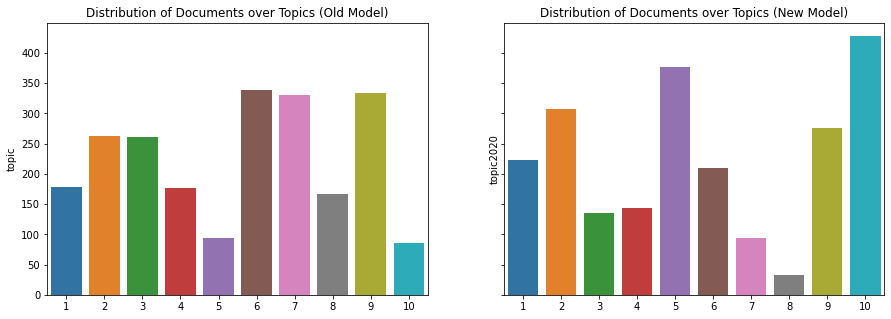

In [63]:
#Plot Distribution of Documents over Topics
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
sns.barplot(x= docs['topic2020'].value_counts().index, y=docs['topic2020'].value_counts(),ax=ax2)
ax2.set_title("Distribution of Documents over Topics (New Model)")
sns.barplot(x= docs['topic'].value_counts().index, y=docs['topic'].value_counts(),ax=ax1)
ax1.set_title("Distribution of Documents over Topics (Old Model)")

To see the change in distribution of topics over documents, we again look at the entropy. Documents in the new model have lower entrophy values than those in the original model with a more right-skewed distribution.

Text(0.5, 1.0, 'Entropy of Distribution of Topics Over Document (Original Model)')

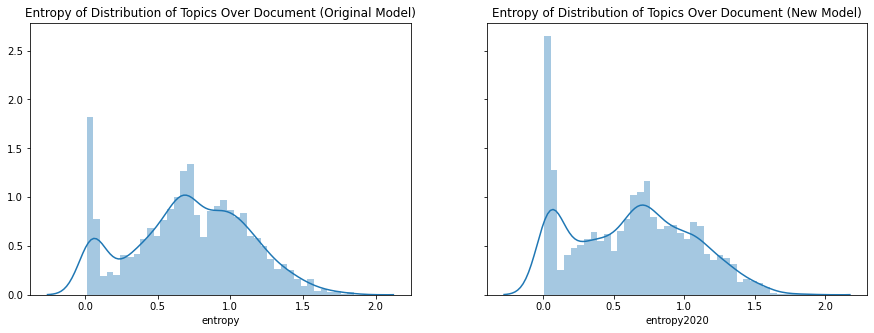

In [64]:
#Plot Entropy of Distribution of Topics Over Document
docs['entropy2020'] = entropy(doc_topic_matrix2020, axis=1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
sns.distplot(docs['entropy2020'],bins=40,ax=ax2)
ax2.set_title("Entropy of Distribution of Topics Over Document (New Model)")
sns.distplot(docs['entropy'],bins=40,ax=ax1)
ax1.set_title("Entropy of Distribution of Topics Over Document (Original Model)")

### Are the documents that were strongly about one topic still about one topic?

Among the documents that originally had a probability of at least 0.8 to assign to 1 topic, only around 61.5% of them are still strong about one topic.

In [65]:
docs['max topic probabilities2020'] =  doc_topic_matrix2020.max(axis=1)
(docs.loc[docs['max topic probabilities'] >0.8, 'max topic probabilities2020']>0.8).mean()

0.6147859922178989

This example shows the instability of model fitting with LDA with random initialization. In reality, the likelihood probability is not smooth but rather bumpy. It is very likely that we stuck on a local maximum and fail to get the best solution. Also, the final space we arrive at also highly depends on where we start the space. That's why with different seeds, the topic models gave different results.

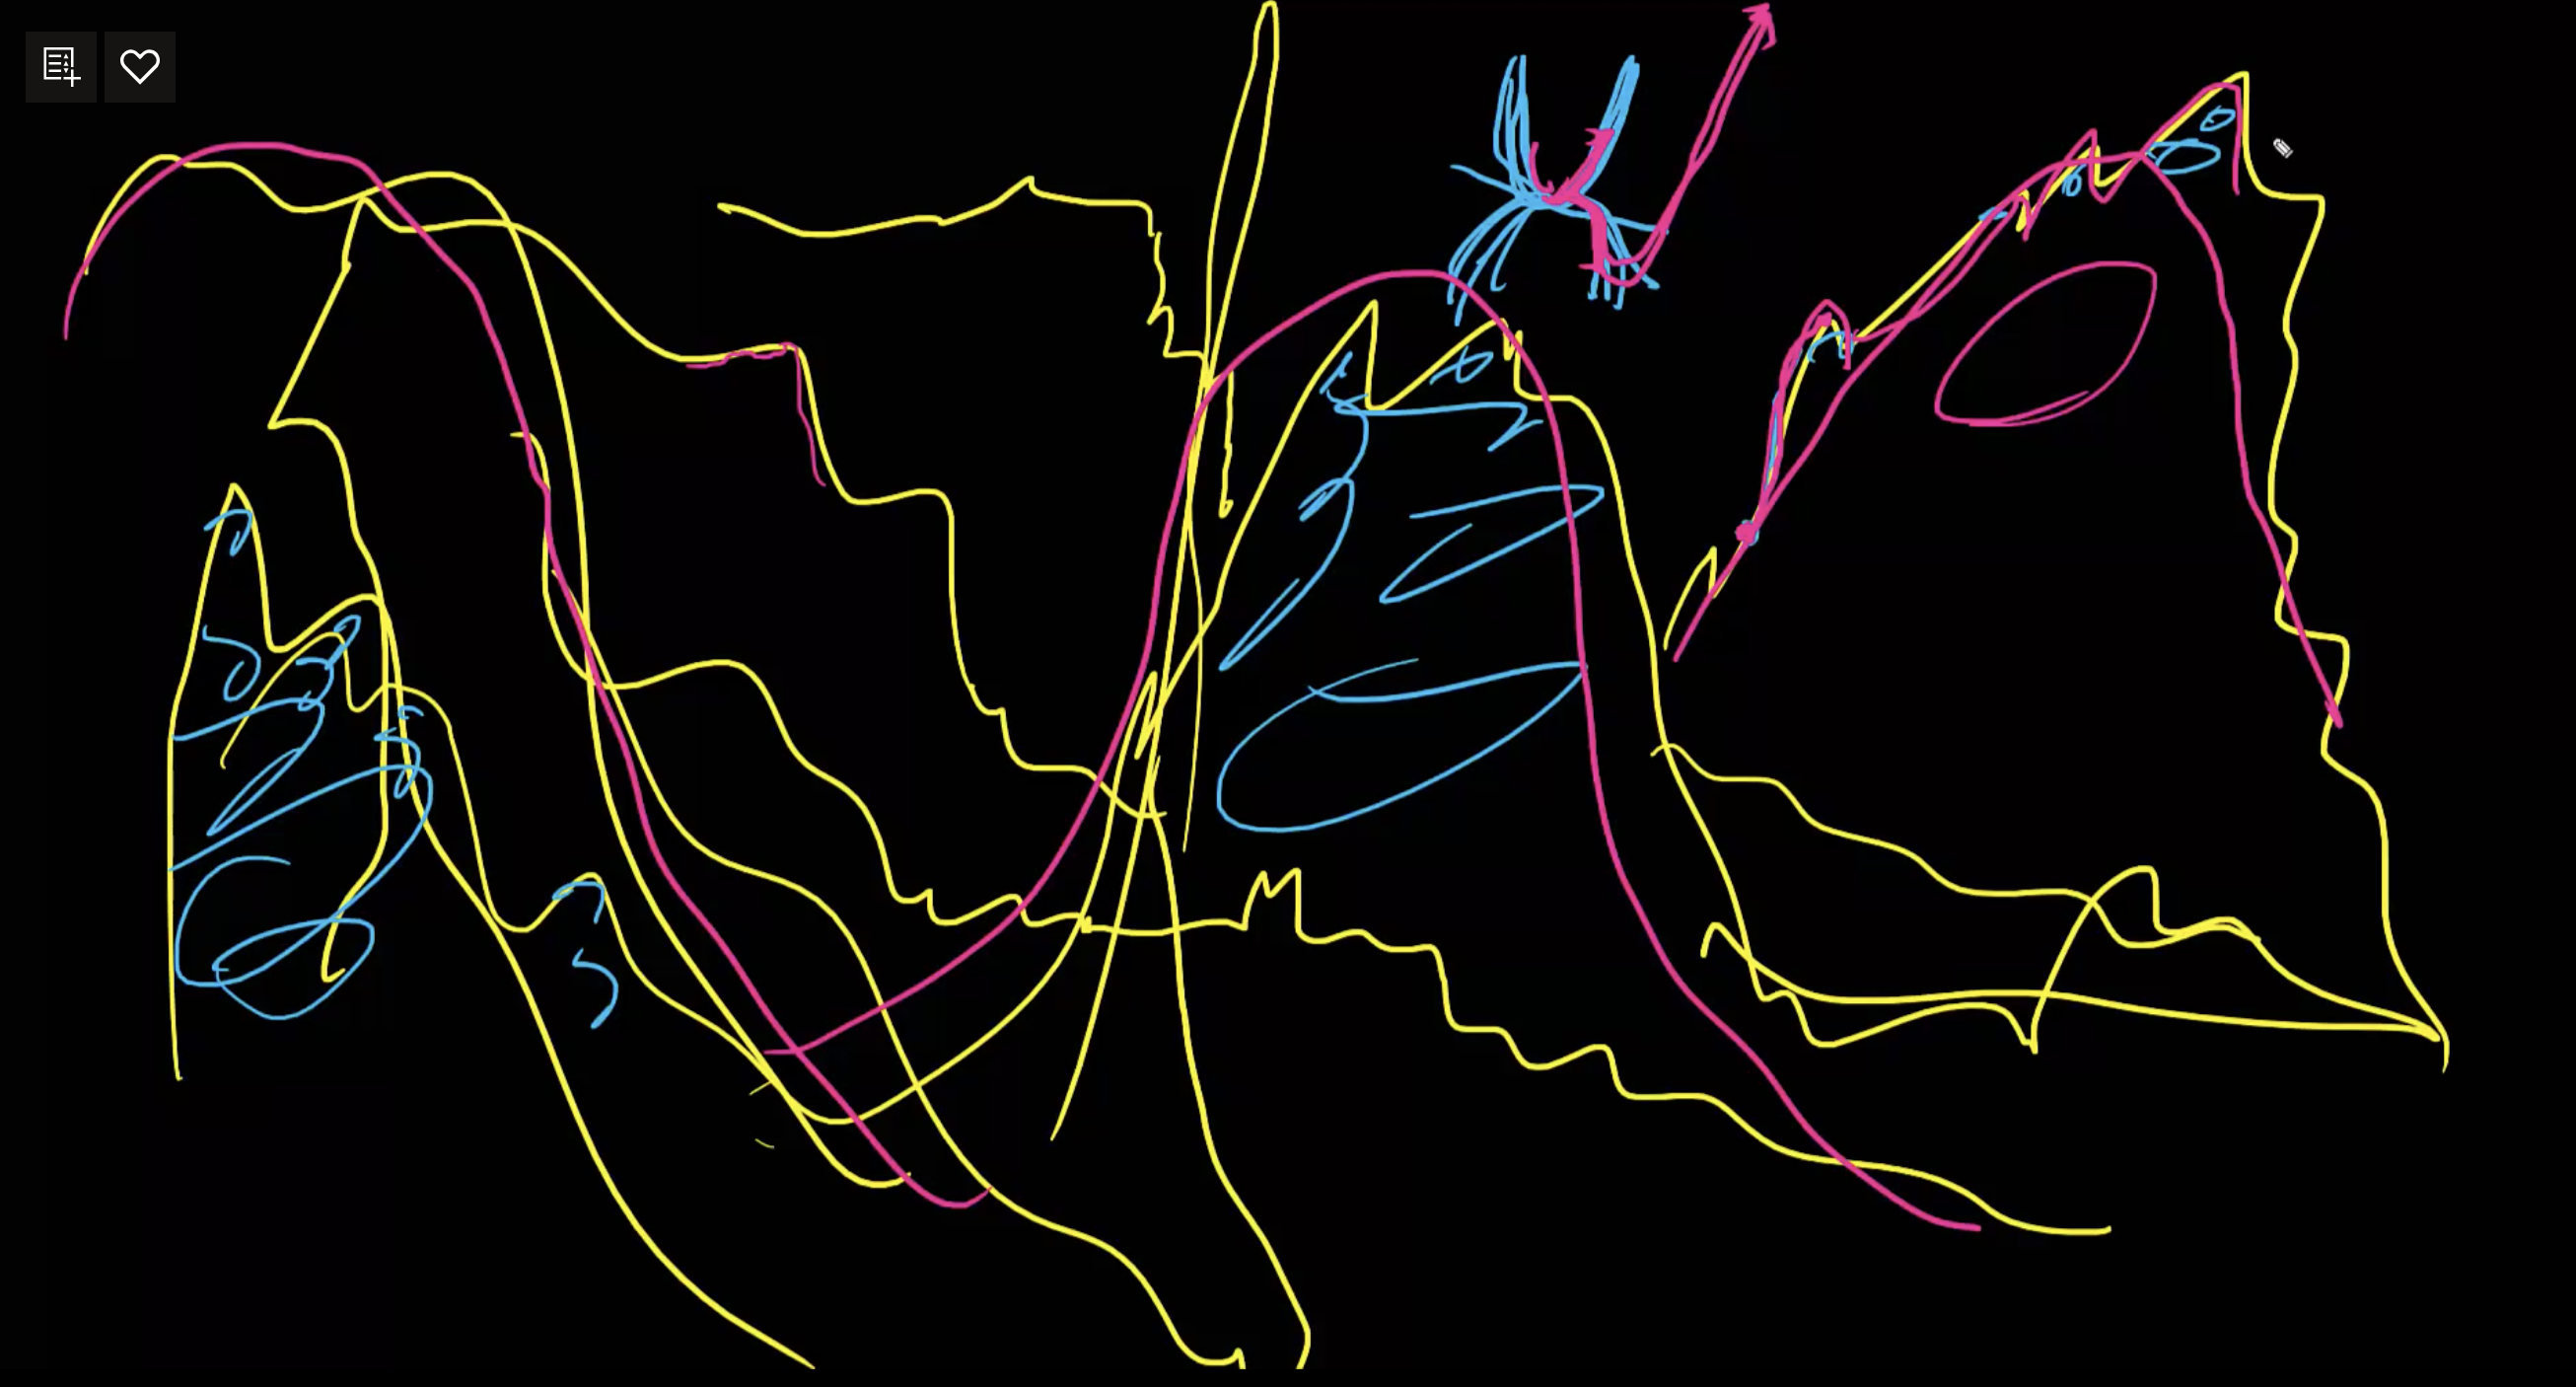

# Question 6 Final Thoughts

Topic models reflect the structure of the data available. There is no ground truth that which model is the right model; rather, topic models are highly unstable. As in our explorations through this homework, topic models depend on many different things: number of top words we choose to interpret the topics, number of topics specified in the model, the data that feeds the model, random initialization, etc.

However, the instability doesn't mean that these models are totally useless. It is just that we need to be very cautious when we use them. We should always use them with human judgements rather than soley rely on them.

